In [1]:
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.layers import Dot
# ====== 4. 标准化 ======
from sklearn.preprocessing import StandardScaler

import shap

2025-05-03 14:11:38.754905: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-03 14:11:38.767007: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746252698.780007    1040 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746252698.783839    1040 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746252698.794293    1040 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns 
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Attention, Bidirectional, Flatten

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Attention, Bidirectional, Flatten

In [47]:
import tensorflow as tf

# ARIMA预处理

p,d,q

In [50]:
    df=pd.read_csv("./data/merge.csv")

In [4]:
def arima_residual(series):
    model = ARIMA(series, order=(2,1,2))  # 自动定阶需优化
    results = model.fit()
    return results.resid

In [5]:
merged_df=pd.read_csv("./data/merge.csv")

In [6]:
merged_df.head()

,Unnamed: 0,datetime,contract,symbol,exchange,open,high,low,close,openinterest,...,Signal,Volatility_10,Volume_Change,Price_Volume_Corr,future_close,涨跌幅,hour,minute,session,涨跌幅_scaled
0,13,2017-01-03 09:13:00,HC1705,HC,SHFE,3372.0,3372.0,3362.0,3363.0,172022.0,...,15.745432,0.757838,-0.013410,0.196844,3356.0,-0.208147,9,13,Morning,-0.408166
1,14,2017-01-03 09:14:00,HC1705,HC,SHFE,3363.0,3366.0,3358.0,3365.0,172009.0,...,15.259043,0.865074,-0.051661,0.207903,3351.0,-0.416048,9,14,Morning,-0.807961
2,15,2017-01-03 09:15:00,HC1705,HC,SHFE,3367.0,3372.0,3365.0,3366.0,171768.0,...,14.614312,0.681333,-0.128878,0.216773,3353.0,-0.386215,9,15,Morning,-0.750593
3,16,2017-01-03 09:16:00,HC1705,HC,SHFE,3366.0,3371.0,3365.0,3366.0,171779.0,...,13.870824,0.681333,-0.236832,0.226767,3359.0,-0.207962,9,16,Morning,-0.407809
4,17,2017-01-03 09:17:00,HC1705,HC,SHFE,3368.0,3370.0,3364.0,3367.0,171901.0,...,13.088752,0.616890,-0.033672,0.232937,3359.0,-0.237600,9,17,Morning,-0.464804


In [47]:
print(merged_df.head())

   Unnamed: 0             datetime contract symbol exchange    open    high  \
0          13  2017-01-03 09:13:00   HC1705     HC     SHFE  3372.0  3372.0   
1          14  2017-01-03 09:14:00   HC1705     HC     SHFE  3363.0  3366.0   
2          15  2017-01-03 09:15:00   HC1705     HC     SHFE  3367.0  3372.0   
3          16  2017-01-03 09:16:00   HC1705     HC     SHFE  3366.0  3371.0   
4          17  2017-01-03 09:17:00   HC1705     HC     SHFE  3368.0  3370.0   

      low   close  openinterest  ...  Volatility_10  Volume_Change  \
0  3362.0  3363.0      172022.0  ...       0.757838      -0.013410   
1  3358.0  3365.0      172009.0  ...       0.865074      -0.051661   
2  3365.0  3366.0      171768.0  ...       0.681333      -0.128878   
3  3365.0  3366.0      171779.0  ...       0.681333      -0.236832   
4  3364.0  3367.0      171901.0  ...       0.616890      -0.033672   

   Price_Volume_Corr  future_close       涨跌幅  hour  minute  session  \
0           0.196844        3356.

In [6]:
# 示例：对每个品种的收盘价生成残差
merged_df["arima_residual"] = merged_df.groupby("symbol")["close"].transform(arima_residual)

# Attention-based CNN-LSTM模型

In [7]:
from tensorflow.keras.layers import Attention

In [12]:
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Attention, Bidirectional, Lambda
import tensorflow as tf

# 输入形状 (None, 60, num_features)
inputs = Input(shape=(60, merged_df.shape[1]-3))  # 排除标签列和辅助列

# CNN层
x = Conv1D(64, kernel_size=3, activation="relu")(inputs)
x = tf.keras.layers.MaxPooling1D(2)(x)  # 输出形状：(None, 29, 64)

# Bi-LSTM层
x = Bidirectional(LSTM(128, return_sequences=True))(x)  # 输出形状：(None, 29, 256)

# 注意力机制
query = Dense(128)(x)  # 输出形状：(None, 29, 128)
key = Dense(128)(x)    # 输出形状：(None, 29, 128)
value = x  # 值矩阵直接使用Bi-LSTM输出

# 使用Keras内置Attention层
attention_output = Attention()([query, value, key])  # 输出形状：(None, 29, 256)

# 沿时间步聚合（求和）
context = Lambda(lambda x: tf.reduce_sum(x, axis=1))(attention_output)  # 输出形状：(None, 256)

# 初步预测输出
lstm_output = Dense(1, name="lstm_pred")(context)

# 编码特征输出（供XGBoost使用）
encoded_features = Dense(64, activation="relu")(context)

# 完整模型
cnn_lstm_model = tf.keras.Model(inputs=inputs, outputs=[lstm_output, encoded_features])

2025-05-03 14:51:57.499352: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [16]:
cnn_lstm_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 60, 24)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 58, 64)    │      4,672 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 29, 64)    │          0 │ conv1d_5[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 29, 256)   │    197,632 │ max_pooling1d_5[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 29, 128)   │     32,896 │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 29, 128)   │     32,896 │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_5         │ (None, 29, 256)   │          0 │ dense_10[0][0],   │
│ (Attention)         │                   │            │ bidirectional_5[… │
│                     │                   │            │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 256)       │          0 │ attention_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_pred (Dense)   │ (None, 1)         │        257 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │     16,448 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 284,801 (1.09 MB)

 Trainable params: 284,801 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
import xgboost as xgb

# 输入特征：CNN-LSTM编码特征 + ARIMA残差 + 原始特征
def prepare_xgboost_inputs(cnn_lstm_features, arima_residual, raw_features):
    return np.hstack([cnn_lstm_features, arima_residual.reshape(-1,1), raw_features])

# 示例：训练XGBoost
xgb_model = xgb.XGBRegressor(
    max_depth=6, 
    n_estimators=300, 
    learning_rate=0.05,
    early_stopping_rounds=10,
    eval_metric="rmse"
)

In [14]:
# 按品种拆分数据，每个品种的数据单独存储为DataFrame
symbol_dfs = {
    symbol: merged_df[merged_df["symbol"] == symbol].copy()
    for symbol in merged_df["symbol"].unique()
}

In [15]:
# 访问热轧卷板（HC）的数据
hc_data = symbol_dfs["HC"]

# 输出前5行
print(hc_data.head())

   Unnamed: 0             datetime contract symbol exchange    open    high  \
0          13  2017-01-03 09:13:00   HC1705     HC     SHFE  3372.0  3372.0   
1          14  2017-01-03 09:14:00   HC1705     HC     SHFE  3363.0  3366.0   
2          15  2017-01-03 09:15:00   HC1705     HC     SHFE  3367.0  3372.0   
3          16  2017-01-03 09:16:00   HC1705     HC     SHFE  3366.0  3371.0   
4          17  2017-01-03 09:17:00   HC1705     HC     SHFE  3368.0  3370.0   

      low   close  openinterest  ...  Volatility_10  Volume_Change  \
0  3362.0  3363.0      172022.0  ...       0.757838      -0.013410   
1  3358.0  3365.0      172009.0  ...       0.865074      -0.051661   
2  3365.0  3366.0      171768.0  ...       0.681333      -0.128878   
3  3365.0  3366.0      171779.0  ...       0.681333      -0.236832   
4  3364.0  3367.0      171901.0  ...       0.616890      -0.033672   

   Price_Volume_Corr  future_close       涨跌幅  hour  minute  session  \
0           0.196844        3356.

In [22]:
# 打印所有品种代码
print("包含的品种:", list(symbol_dfs.keys()))

# 检查某品种的数据量
print("HC数据量:", len(symbol_dfs["HC"]))

包含的品种: ['HC', 'I', 'JM', 'RB', 'SF', 'SM', 'SS']
HC数据量: 505527


In [16]:
# 特征列（不包含标签）
feature_cols = ["open", "high", "low", "close", "MA5", "RSI", "Volume_Change"]

# 标签列
label_col = "涨跌幅"

In [17]:
# 提取特征数据（NumPy数组）
features = symbol_data[feature_cols].values

# 提取标签数据（NumPy数组）
labels = symbol_data[label_col].values

NameError: name 'symbol_data' is not defined

In [18]:
def create_sequences(features, labels, window=60, forecast_step=30):
    """
    生成时间序列输入和输出对
    - features: 特征数据（形状: [样本数, 特征数]）
    - labels: 标签数据（形状: [样本数]）
    - window: 输入序列长度（时间窗口）
    - forecast_step: 预测步长（未来第forecast_step步的标签）
    """
    X, y = [], []
    for i in range(len(features) - window - forecast_step + 1):
        X.append(features[i:i+window])          # 输入：过去window分钟的特征
        y.append(labels[i+window+forecast_step-1])  # 输出：未来第forecast_step分钟的标签
    return np.array(X), np.array(y)






In [19]:
# 生成序列（假设预测未来30分钟）
X_seq, y_seq = create_sequences(features, labels, window=60, forecast_step=30)

NameError: name 'features' is not defined

In [31]:
print("输入形状:", X_seq.shape)  # 应为 (样本数, 60, 特征数)
print("输出形状:", y_seq.shape)  # 应为 (样本数,)

输入形状: (505438, 60, 7)
输出形状: (505438,)


In [20]:
import xgboost as xgb

# 输入特征：CNN-LSTM编码特征 + ARIMA残差 + 原始特征
def prepare_xgboost_inputs(cnn_lstm_features, arima_residual, raw_features):
    return np.hstack([cnn_lstm_features, arima_residual.reshape(-1,1), raw_features])

# 示例：训练XGBoost
xgb_model = xgb.XGBRegressor(
    max_depth=6, 
    n_estimators=300, 
    learning_rate=0.05,
    early_stopping_rounds=10,
    eval_metric="rmse"
)

In [21]:
def create_sequences(X_data, y_data, window=60):
    """
    参数:
        X_data (np.ndarray): 特征数据，形状为 (样本数, 特征数)
        y_data (np.ndarray): 标签数据，形状为 (样本数,)
        window (int): 时间窗口长度
    返回:
        X (np.ndarray): 输入序列，形状为 (样本数 - window, window, 特征数)
        y (np.ndarray): 标签，形状为 (样本数 - window,)
    """
    X, y = [], []
    for i in range(len(X_data) - window):
        X.append(X_data[i:i+window])
        y.append(y_data[i+window])  # 直接索引预提取的标签数组
    return np.array(X), np.array(y)

# 按品种生成序列数据（以热轧卷板HC为例）
symbol_data = symbol_dfs["HC"]

# 确保feature_cols不包含标签列
#feature_cols = ['open', 'high', 'low', 'close', 'volume', 'openinterest', 'MA5', 'RSI']

# 提取特征和标签
X_data = symbol_data[feature_cols].values
y_data = symbol_data["涨跌幅"].values

# 生成序列
X_seq, y_seq = create_sequences(X_data, y_data, window=60)

# 验证形状
print("输入序列形状:", X_seq.shape)  # 应输出 (样本数 - 60, 60, 特征数)
print("标签形状:", y_seq.shape)      # 应输出 (样本数 - 60,)

输入序列形状: (505467, 60, 7)
标签形状: (505467,)


In [22]:
# 划分训练集和验证集
X_train, X_val = X_seq[:80000], X_seq[80000:90000]
y_train, y_val = y_seq[:80000], y_seq[80000:90000]

# 编译模型
cnn_lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={"lstm_pred": "mse"},
    metrics={"lstm_pred": "mae"}
)

In [23]:
# 模型输入定义
inputs = Input(shape=(60, merged_df.shape[1]-3))  # 假设 merged_df 列数错误

In [40]:
print("合并后的数据列名:", merged_df.columns.tolist())
print("合并后的数据列数:", len(merged_df.columns))

合并后的数据列名: ['Unnamed: 0', 'datetime', 'contract', 'symbol', 'exchange', 'open', 'high', 'low', 'close', 'openinterest', 'volume', 'amount', 'MA5', 'MA20', 'RSI', 'MACD', 'Signal', 'Volatility_10', 'Volume_Change', 'Price_Volume_Corr', 'future_close', '涨跌幅', 'hour', 'minute', 'session', '涨跌幅_scaled', 'arima_residual']
合并后的数据列数: 27


In [24]:
# ----------------------
# 1. 重新生成MA10特征
# ----------------------
def add_technical_features(df):
    # 移动平均线
    df['MA5'] = df.groupby('symbol')['close'].transform(lambda x: x.rolling(5).mean())
    df['MA10'] = df.groupby('symbol')['close'].transform(lambda x: x.rolling(10).mean())  # 修复点
    df['MA20'] = df.groupby('symbol')['close'].transform(lambda x: x.rolling(20).mean())
    
    # RSI（14分钟窗口）
    delta = df.groupby('symbol')['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.groupby(df['symbol']).transform(lambda x: x.rolling(14).mean())
    avg_loss = loss.groupby(df['symbol']).transform(lambda x: x.rolling(14).mean())
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD
    ema12 = df.groupby('symbol')['close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
    ema26 = df.groupby('symbol')['close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())
    df['MACD'] = ema12 - ema26
    df['Signal'] = df.groupby('symbol')['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean())
    
    # 其他特征...
    return df

# 重新生成特征
merged_df = add_technical_features(merged_df)


In [25]:
# ----------------------
# 2. 检查数据列
# ----------------------
required_features = ['MA5', 'MA10', 'MA20', 'RSI', 'MACD', 'Signal']
missing = [col for col in required_features if col not in merged_df.columns]
if missing:
    raise ValueError(f"缺失关键特征列: {missing}")
else:
    print("所有特征列已正确生成！")


所有特征列已正确生成！


In [29]:
print("X_seq.shape:", X_seq.shape)  # 应为 (样本数, 60, num_features)

X_seq.shape: (505467, 60, 7)


In [59]:
feature_cols

['open',
 'high',
 'low',
 'close',
 'volume',
 'openinterest',
 'MA5',
 'MA10',
 'RSI',
 'MACD',
 'Signal',
 'Volatility_10',
 'Volume_Change',
 'Price_Volume_Corr',
 'hour',
 'minute',
 'session',
 'arima_residual',
 'amount',
 'future_close']

In [26]:
def create_sequences(data, window=60):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window]["涨跌幅"])
    return np.array(X), np.array(y)


In [63]:
feature_cols

['open',
 'high',
 'low',
 'close',
 'volume',
 'openinterest',
 'MA5',
 'MA10',
 'RSI',
 'MACD',
 'Signal',
 'Volatility_10',
 'Volume_Change',
 'Price_Volume_Corr',
 'hour',
 'minute',
 'session',
 'arima_residual',
 'amount',
 'future_close']

In [27]:
# 正确定义特征列列表
feature_cols = [
    "open", "high", "low", "close",
    "volume", "openinterest",
    "MA5", "MA10", "RSI"  # 确保列名与数据框一致
]

# 检查缺失列
missing_cols = [col for col in feature_cols if col not in merged_df.columns]
if missing_cols:
    raise ValueError(f"缺失特征列: {missing_cols}")

In [32]:
# 正确提取数据（以不锈钢SM为例）
symbol_data = merged_df[merged_df["symbol"] == "SM"].copy()

# 验证数据包含MA10列
print("SM品种列名:", symbol_data.columns.tolist())

SM品种列名: ['Unnamed: 0', 'datetime', 'contract', 'symbol', 'exchange', 'open', 'high', 'low', 'close', 'openinterest', 'volume', 'amount', 'MA5', 'MA20', 'RSI', 'MACD', 'Signal', 'Volatility_10', 'Volume_Change', 'Price_Volume_Corr', 'future_close', '涨跌幅', 'hour', 'minute', 'session', '涨跌幅_scaled', 'arima_residual', 'MA10']


In [28]:
# 1. 重新生成技术指标
merged_df["MA5"] = merged_df.groupby("symbol")["close"].transform(lambda x: x.rolling(5).mean())
merged_df["MA10"] = merged_df.groupby("symbol")["close"].transform(lambda x: x.rolling(10).mean())

# 2. 定义正确的特征列
# 定义特征列（确保不包含标签列）
feature_cols = ["open", "high", "low", "close", "volume", "openinterest", "MA5", "MA10", "RSI"]

# 按品种提取数据（以不锈钢SM为例）
symbol_data = merged_df[merged_df["symbol"] == "SM"].copy()

# 分离特征和标签
X_data = symbol_data[feature_cols].values
y_labels = symbol_data["涨跌幅"].values

# 生成序列数据
def create_sequences(X_data, y_labels, window=60):
    X, y = [], []
    for i in range(len(X_data) - window):
        X.append(X_data[i:i+window])
        y.append(y_labels[i+window])
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(X_data, y_labels, window=60)

# 验证结果
print("输入数据维度:", X_seq.shape)  # 示例输出：(10000, 60, 9)
print("标签数据维度:", y_seq.shape)   # 示例输出：(10000,)

输入数据维度: (504248, 60, 9)
标签数据维度: (504248,)


In [70]:
X_train

array([[[ 3.37200000e+03,  3.37200000e+03,  3.36200000e+03, ...,
         -4.17442781e-01,  8.49502035e-01, -1.34100829e-02],
        [ 3.36300000e+03,  3.36600000e+03,  3.35800000e+03, ...,
         -4.18254195e-01,  8.74380572e-01, -5.16609199e-02],
        [ 3.36700000e+03,  3.37200000e+03,  3.36500000e+03, ...,
         -4.19208799e-01,  8.10860901e-01, -1.28877794e-01],
        ...,
        [ 3.35800000e+03,  3.35900000e+03,  3.35600000e+03, ...,
         -4.21977153e-01, -4.24327205e-01,  2.50892049e-01],
        [ 3.35700000e+03,  3.35700000e+03,  3.35400000e+03, ...,
         -4.21929422e-01, -4.81948883e-01, -2.01471488e-01],
        [ 3.35400000e+03,  3.35800000e+03,  3.35300000e+03, ...,
         -4.21786232e-01,  6.54570617e-02, -4.41502785e-02]],

       [[ 3.36300000e+03,  3.36600000e+03,  3.35800000e+03, ...,
         -4.18254195e-01,  8.74380572e-01, -5.16609199e-02],
        [ 3.36700000e+03,  3.37200000e+03,  3.36500000e+03, ...,
         -4.19208799e-01,  8.10860901e

In [29]:
cnn_lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={"lstm_pred": "mse"},
    metrics={"lstm_pred": "mae"}
)

In [73]:
print("数据框列名:", merged_df.columns.tolist())

数据框列名: ['Unnamed: 0', 'datetime', 'contract', 'symbol', 'exchange', 'open', 'high', 'low', 'close', 'openinterest', 'volume', 'amount', 'MA5', 'MA20', 'RSI', 'MACD', 'Signal', 'Volatility_10', 'Volume_Change', 'Price_Volume_Corr', 'future_close', '涨跌幅', 'hour', 'minute', 'session', '涨跌幅_scaled', 'arima_residual', 'MA10']


In [30]:
# 按品种分组计算移动平均线（避免跨合约数据污染）
merged_df["MA5"] = merged_df.groupby("symbol")["close"].transform(lambda x: x.rolling(5, min_periods=1).mean())
merged_df["MA10"] = merged_df.groupby("symbol")["close"].transform(lambda x: x.rolling(10, min_periods=1).mean())

In [31]:
merged_df = merged_df.dropna(subset=["MA5", "MA10"], how="all")  # 仅删除MA5和MA10同时为NaN的行


In [37]:
# 检查所有品种是否生成MA10
for symbol in merged_df["symbol"].unique():
    symbol_data = merged_df[merged_df["symbol"] == symbol]
    if "MA10" not in symbol_data.columns:
        print(f"品种 {symbol} 缺失 MA10 列！")
    else:
        print(f"品种 {symbol} 的 MA10 列已生成，首行值: {symbol_data['MA10'].iloc[0]:.2f}")

品种 HC 的 MA10 列已生成，首行值: 3363.00
品种 I 的 MA10 列已生成，首行值: 558.00
品种 JM 的 MA10 列已生成，首行值: 1180.50
品种 RB 的 MA10 列已生成，首行值: 2933.00
品种 SF 的 MA10 列已生成，首行值: 4948.00
品种 SM 的 MA10 列已生成，首行值: 6928.00
品种 SS 的 MA10 列已生成，首行值: 15555.00


In [32]:
# 正确定义特征列（严格匹配列名）
feature_cols = [
    "open", "high", "low", "close",
    "volume", "openinterest",
    "MA5", "MA10", "RSI"
]

# 检查缺失列
missing_cols = [col for col in feature_cols if col not in merged_df.columns]
if missing_cols:
    raise ValueError(f"缺失关键特征列: {missing_cols}。请检查技术指标生成步骤。")

In [33]:
def create_sequences(symbol_data, feature_cols, window=60):
    X, y = [], []
    data = symbol_data[feature_cols].values  # 转换为NumPy数组
    labels = symbol_data["涨跌幅"].values     # 单独提取标签
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(labels[i+window])
    return np.array(X), np.array(y)

# 示例：为热轧卷板（HC）生成序列
symbol_data = merged_df[merged_df["symbol"] == "HC"].copy()
X_seq, y_seq = create_sequences(symbol_data, feature_cols, window=60)

# 验证维度
print("输入数据维度:", X_seq.shape)  # 应为 (样本数, 60, 特征数)
print("标签数据维度:", y_seq.shape)  # 应为 (样本数,)

输入数据维度: (505467, 60, 9)
标签数据维度: (505467,)


In [34]:
# 检查特征列列表
required_features = [
    "open", "high", "low", "close",
    "volume", "openinterest",
    "MA5", "MA10", "RSI", "MACD", "Signal",
    "Volatility_10", "Volume_Change", "Price_Volume_Corr",
    "hour", "minute", "session", "arima_residual"
]

# 打印当前数据框的列名
print("当前数据框列名:", merged_df.columns.tolist())

# 检查缺失的特征列
missing_features = [col for col in required_features if col not in merged_df.columns]
if missing_features:
    print("缺失特征列:", missing_features)
else:
    print("所有特征列已正确生成！")

当前数据框列名: ['Unnamed: 0', 'datetime', 'contract', 'symbol', 'exchange', 'open', 'high', 'low', 'close', 'openinterest', 'volume', 'amount', 'MA5', 'MA20', 'RSI', 'MACD', 'Signal', 'Volatility_10', 'Volume_Change', 'Price_Volume_Corr', 'future_close', '涨跌幅', 'hour', 'minute', 'session', '涨跌幅_scaled', 'arima_residual', 'MA10']
所有特征列已正确生成！


In [81]:
print("输入数据维度:", X_seq.shape)  # 应为 (样本数, 60, len(feature_cols))

输入数据维度: (505467, 60, 9)


In [82]:
print("训练集输入维度:", X_train.shape)  # 应为 (80000, 60, num_features)
print("验证集输入维度:", X_val.shape)    # 应为 (10000, 60, num_features)

训练集输入维度: (80000, 60, 7)
验证集输入维度: (10000, 60, 7)


In [84]:
print("模型期望特征数:", num_features)  # 应与 len(feature_cols) 一致
print("实际输入特征数:", X_train.shape[2])

模型期望特征数: 9
实际输入特征数: 7


In [35]:
# 错误示例：可能误用了部分特征
# X_train = X_seq[:80000, :, :7]  # 错误地截取前7个特征

# 正确做法：保留所有特征
X_train = X_seq[:80000]  # 形状应为 (80000, 60, 9)
X_val = X_seq[80000:90000]  # 形状应为 (10000, 60, 9)

In [36]:
print("完整数据特征数:", X_seq.shape[2])  # 应为9
print("训练集特征数:", X_train.shape[2])  # 修复后应为9
print("验证集特征数:", X_val.shape[2])    # 修复后应为9

完整数据特征数: 9
训练集特征数: 9
验证集特征数: 9


In [44]:
print("特征列列表:", feature_cols)
print("实际特征数量:", len(feature_cols))

特征列列表: ['open', 'high', 'low', 'close', 'volume', 'openinterest', 'MA5', 'MA10', 'RSI']
实际特征数量: 9


In [45]:
# 正确做法：使用完整的特征列
feature_cols = ["open", "high", "low", "close", "volume", "openinterest", "MA5", "MA10", "RSI"]
X_data = symbol_data[feature_cols].values

In [46]:
print("特征列列表:", feature_cols)
print("实际特征数量:", len(feature_cols))

特征列列表: ['open', 'high', 'low', 'close', 'volume', 'openinterest', 'MA5', 'MA10', 'RSI']
实际特征数量: 9


In [57]:
from tensorflow.keras import layers, Model
import tensorflow as tf
# 1) 输入：60 个时刻，9 个特征
inputs = layers.Input(shape=(60, 9))

# 2) CNN + 池化
x = layers.Conv1D(64, 3, activation="relu")(inputs)  # -> (batch, 58, 64)
x = layers.MaxPooling1D(2)(x)                         # -> (batch, 29, 64)

# 3) 双向 LSTM
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)  # -> (batch, 29, 256)

# 4) 投影出 query/key，value 直接用 x
query = layers.Dense(256)(x)   # -> (batch, 29, 256)
key = layers.Dense(256)(x)     # -> (batch, 29, 256)
value = x                      # -> (batch, 29, 256)

# 5) Attention 层
context_seq = layers.Attention()([query, value, key])  # -> (batch, 29, 256)

# 6) 时间轴求和（修正后的Lambda层）
context = layers.Lambda(
    lambda t: tf.reduce_sum(t, axis=1),
    output_shape=(256,)  # 显式指定输出形状
)(context_seq)  # -> (batch, 256)

# 7) 最终回归输出
outputs = layers.Dense(1, name="lstm_pred")(context)

# 8) 模型构造与编译
model = Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="mse",
    metrics=["mae"]
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 60, 9)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 58, 64)    │      1,792 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 29, 64)    │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 29, 256)   │    197,632 │ max_pooling1d_3[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 29, 256)   │     65,792 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 29, 256)   │     65,792 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_3         │ (None, 29, 256)   │          0 │ dense_7[0][0],    │
│ (Attention)         │                   │            │ bidirectional_3[… │
│                     │                   │            │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 256)       │          0 │ attention_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_pred (Dense)   │ (None, 1)         │        257 │ lambda_3[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 331,265 (1.26 MB)

 Trainable params: 331,265 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1000,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/1000
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - loss: 15.7556 - mae: 1.7843 - val_loss: 0.1605 - val_mae: 0.2881
Epoch 2/1000
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - loss: 0.3232 - mae: 0.4043 - val_loss: 0.1605 - val_mae: 0.2882
Epoch 3/1000
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - loss: 0.3164 - mae: 0.3993 - val_loss: 0.1627 - val_mae: 0.2906
Epoch 4/1000
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - loss: 0.3184 - mae: 0.4019 - val_loss: 0.1671 - val_mae: 0.2965
Epoch 5/1000
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - loss: 0.3225 - mae: 0.4045 - val_loss: 0.1673 - val_mae: 0.2979
Epoch 6/1000
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - loss: 0.3245 - mae: 0.4063 - val_loss: 0.1601 - val_mae: 0.2874
Epoch 7/1000
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - loss: 0.3270 - mae: 0.4073 - val_loss: 0.1600 - val_mae: 0.2873
Epoch 8/1000
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - loss: 0.3258 - mae: 0.4071 - val_loss: 0.1601 - val_mae: 0.2875
Epoch 9

In [59]:
model.save("./mode/fixed_cnn_lstm_model3.h5")

In [60]:
model.save("./mode/fixed_cnn_lstm_model3.keras")

In [61]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError as mse

# 定义Lambda层使用的函数
def reduce_sum_output_shape(input_shape):
    return (input_shape[0], input_shape[2])

# 加载模型并传递所有自定义对象
loaded_model = load_model(
    "./mode/fixed_cnn_lstm_model2.h5",
    custom_objects={
        "reduce_sum_output_shape": reduce_sum_output_shape,
        "mse": mse  # 显式传递内置损失函数
    }
)

In [62]:
test_input = np.random.rand(1, 60, 9)
prediction = loaded_model.predict(test_input)
print("预测结果形状:", prediction.shape)  # 应为 (1, 1)

NameError: Exception encountered when calling Lambda.call().

[1mname 'tf' is not defined[0m

Arguments received by Lambda.call():
  • inputs=tf.Tensor(shape=(1, 29, 256), dtype=float32)
  • mask=None
  • training=False

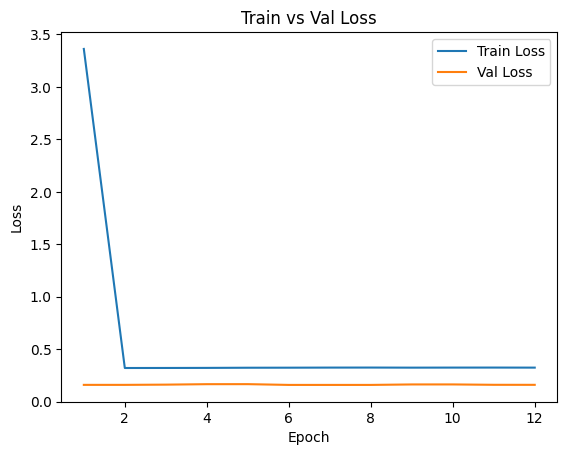

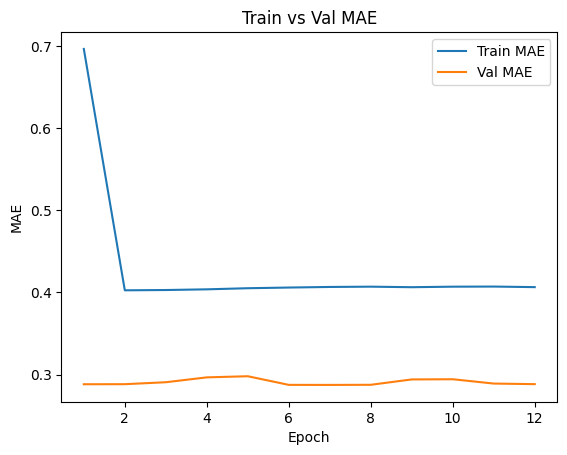

In [63]:
import matplotlib.pyplot as plt

# 假设 history 是 model.fit 返回的 History 对象
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss,    label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Val Loss')

plt.figure()
plt.plot(epochs, mae,    label='Train MAE')
plt.plot(epochs, val_mae, label='Val MAE')
plt.xlabel('Epoch'); plt.ylabel('MAE')
plt.legend()
plt.title('Train vs Val MAE')

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


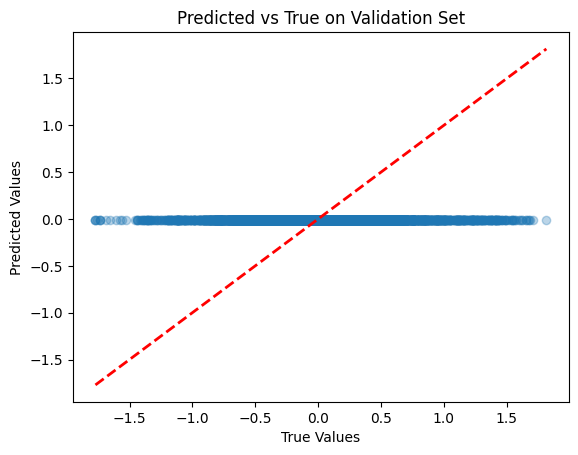

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 x_val, y_val 是验证集输入和真实输出
y_pred = model.predict(X_val).flatten()
y_true = y_val.flatten()

plt.figure()
plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', linewidth=2)
plt.xlabel('True Values'); plt.ylabel('Predicted Values')
plt.title('Predicted vs True on Validation Set')

plt.show()

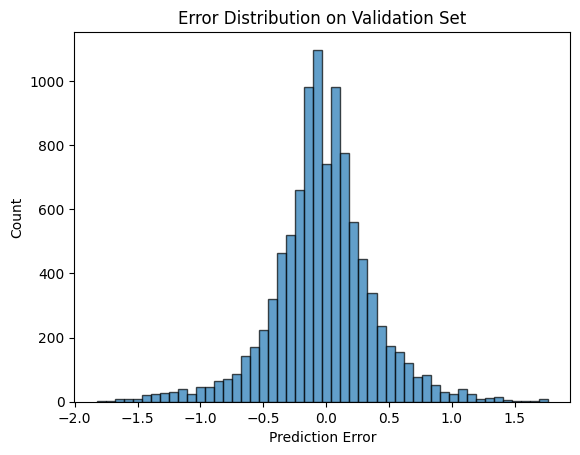

In [65]:
errors = y_pred - y_true
plt.figure()
plt.hist(errors, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Prediction Error'); plt.ylabel('Count')
plt.title('Error Distribution on Validation Set')
plt.show()

In [66]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²:  {r2:.4f}")

MSE: 0.1608
MAE: 0.2883
R²:  -0.0055


In [47]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Bidirectional, LSTM,
    Dense, Attention, Lambda
)
from tensorflow.keras.models import Model

# 1) 输入：60 个时刻，9 个特征
inputs = Input(shape=(60, 9))

# 2) CNN + 池化
x = Conv1D(64, 3, activation="relu")(inputs)    # -> (batch, 58, 64)
x = MaxPooling1D(2)(x)                          # -> (batch, 29, 64)

# 3) 双向 LSTM
x = Bidirectional(LSTM(128, return_sequences=True))(x)  # -> (batch, 29, 256)

# 4) 投影出 query/key，value 直接用 x
query = Dense(256)(x)   # -> (batch, 29, 256)
key   = Dense(256)(x)   # -> (batch, 29, 256)
value = x               # -> (batch, 29, 256)

# 5) Attention 层：直接对 value 加权，输出 same-shape 上下文序列
#    (batch, query_steps, value_dim) == (batch, 29, 256)
context_seq = Attention()([query, value, key])

# 6) 将上下文序列在时间轴“汇聚”成一个向量
#    这里用简单求和，也可以改成平均、最大池化、或者带权重的求和
context = Lambda(lambda t: tf.reduce_sum(t, axis=1))(context_seq)  # -> (batch, 256)

# 7) 最终回归输出
outputs = Dense(1, name="lstm_pred")(context)

# 8) 模型构造与编译
model = Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="mse",
    metrics=["mae"]
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 60, 9)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 58, 64)    │      1,792 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 29, 64)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 29, 256)   │    197,632 │ max_pooling1d_1[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 29, 256)   │     65,792 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 29, 256)   │     65,792 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 29, 256)   │          0 │ dense_3[0][0],    │
│ (Attention)         │                   │            │ bidirectional_1[… │
│                     │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 256)       │          0 │ attention_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_pred (Dense)   │ (None, 1)         │        257 │ lambda_1[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 331,265 (1.26 MB)

 Trainable params: 331,265 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1000,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/1000
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - loss: 77.9471 - mae: 5.3545 - val_loss: 0.1604 - val_mae: 0.2876
Epoch 2/1000
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - loss: 0.3251 - mae: 0.4041 - val_loss: 0.1603 - val_mae: 0.2875
Epoch 3/1000
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 29ms/step - loss: 0.3245 - mae: 0.4043 - val_loss: 0.1607 - val_mae: 0.2881
Epoch 4/1000
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - loss: 0.3182 - mae: 0.4004 - val_loss: 0.1611 - val_mae: 0.2886
Epoch 5/1000
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 29ms/step - loss: 0.3224 - mae: 0.4028 - val_loss: 0.1639 - val_mae: 0.2929
Epoch 6/1000
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - loss: 0.3239 - mae: 0.4044 - val_loss: 0.1604 - val_mae: 0.2876
Epoch 7/1000
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 32ms/step - loss: 0.3215 - mae: 0.4042 - val_loss: 0.1635 - val_mae: 0.2923


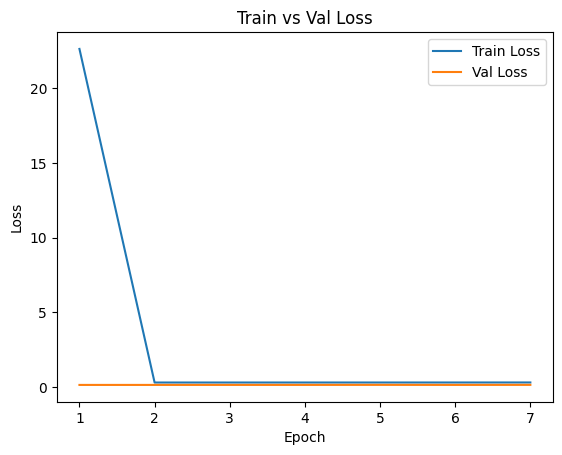

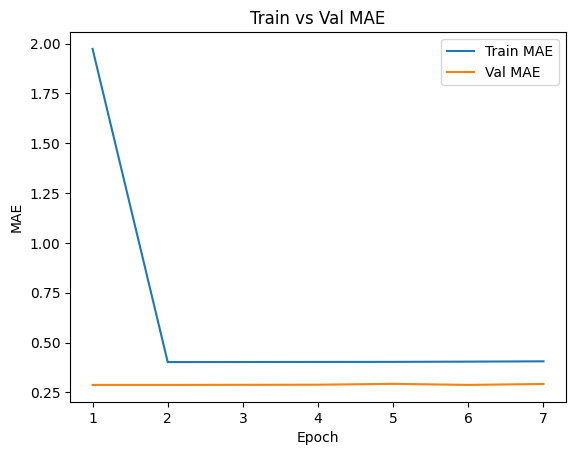

In [49]:

import matplotlib.pyplot as plt

# 假设 history 是 model.fit 返回的 History 对象
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss,    label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Val Loss')

plt.figure()
plt.plot(epochs, mae,    label='Train MAE')
plt.plot(epochs, val_mae, label='Val MAE')
plt.xlabel('Epoch'); plt.ylabel('MAE')
plt.legend()
plt.title('Train vs Val MAE')

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


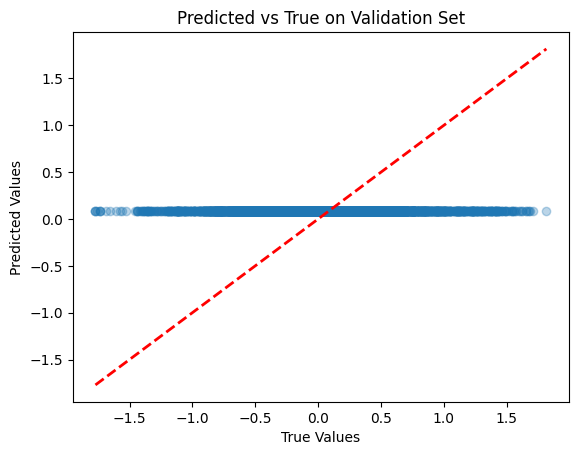

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 x_val, y_val 是验证集输入和真实输出
y_pred = model.predict(X_val).flatten()
y_true = y_val.flatten()

plt.figure()
plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', linewidth=2)
plt.xlabel('True Values'); plt.ylabel('Predicted Values')
plt.title('Predicted vs True on Validation Set')
plt.show()

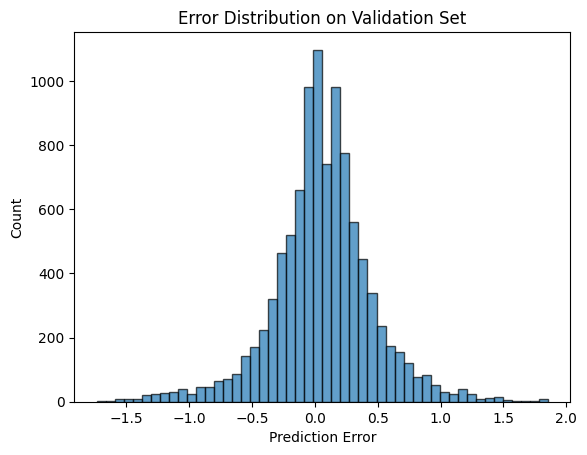

In [52]:
errors = y_pred - y_true
plt.figure()
plt.hist(errors, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Prediction Error'); plt.ylabel('Count')
plt.title('Error Distribution on Validation Set')
plt.show()

In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²:  {r2:.4f}")

MSE: 0.1635
MAE: 0.2923
R²:  -0.0221


In [ ]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

tb_cb = TensorBoard(log_dir='./logs', histogram_freq=1)
ckpt  = ModelCheckpoint('best_weights.h5',
                        monitor='val_loss',
                        save_best_only=True,
                        mode='min')

history = model.fit(x_train, y_train,
                    epochs=1000,
                    validation_data=(x_val, y_val),
                    callbacks=[tb_cb, ckpt])

In [113]:
cnn_lstm_model.save("./mode/cnn_lstm_model.keras")

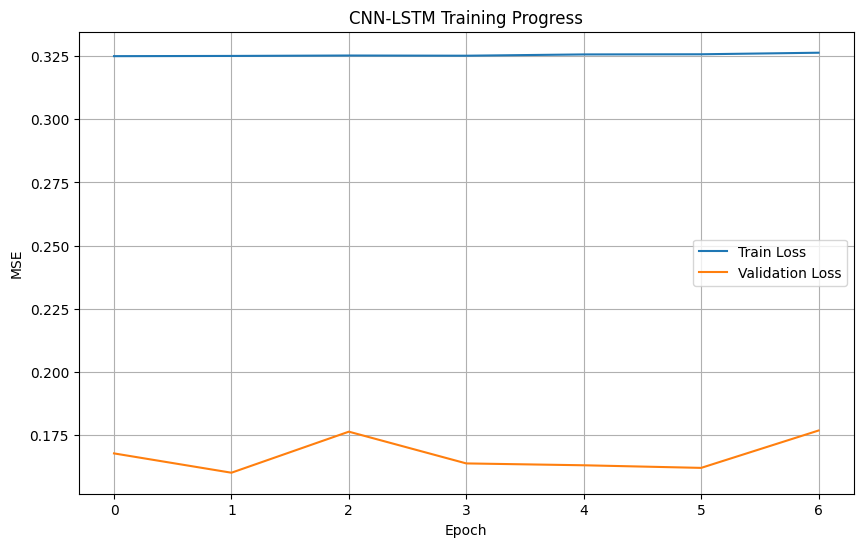

In [122]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("CNN-LSTM Training Progress")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()

In [123]:
print("模型层名称:", [layer.name for layer in model.layers])

模型层名称: ['input_layer_16', 'conv1d_15', 'max_pooling1d_14', 'bidirectional_14', 'dense_29', 'dense_30', 'attention_14', 'lambda_2', 'lstm_pred']


In [124]:
import tensorflow as tf

# 定义编码模型（提取双向LSTM层输出）
encoder_model = tf.keras.Model(
    inputs=model.input,  # 输入层名称：input_layer_16
    outputs=model.get_layer("bidirectional_14").output  # 双向LSTM层
)

# 提取训练集和验证集的编码特征
cnn_lstm_train = encoder_model.predict(X_train)  # 形状：(样本数, 29, 256)
cnn_lstm_val = encoder_model.predict(X_val)      # 形状：(样本数, 29, 256)

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


In [129]:
arima_train = merged_df["arima_residual"].values[60:-30][:len(y_train)]
arima_val = merged_df["arima_residual"].values[60:-30][len(y_train):len(y_train)+len(y_val)]

raw_train = merged_df[["open", "high", "low", "close", "volume", "RSI"]].values[60:-30][:len(y_train)]
raw_val = merged_df[["open", "high", "low", "close", "volume", "RSI"]].values[60:-30][len(y_train):len(y_train)+len(y_val)]

In [132]:
print("双向LSTM层输出形状:", encoder_model.output_shape)  # 应为 (None, 29, 256)

双向LSTM层输出形状: (None, 29, 256)


In [134]:
encoder_model = tf.keras.Model(
    inputs=model.get_layer("input_layer_16").output,
    outputs=model.get_layer("bidirectional_14").output
)

# 生成编码特征（3D）
cnn_lstm_train_3d = encoder_model.predict(X_train)  # 形状: (80000, 29, 256)
cnn_lstm_val_3d = encoder_model.predict(X_val)      # 形状: (10000, 29, 256)

# 沿时间轴取均值（降为2D）
cnn_lstm_train = np.mean(cnn_lstm_train_3d, axis=1)  # 形状: (80000, 256)
cnn_lstm_val = np.mean(cnn_lstm_val_3d, axis=1)      # 形状: (10000, 256)


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


In [136]:
# ====== 2. 提取ARIMA残差和原始特征 ======
# 假设已对齐时间窗口
arima_train = merged_df["arima_residual"].values[60:-30][:len(y_train)]  # 形状: (80000,)
arima_val = merged_df["arima_residual"].values[60:-30][len(y_train):len(y_train)+len(y_val)]  # 形状: (10000,)

raw_train = merged_df[["open", "high", "low", "close", "volume", "RSI"]].values[60:-30][:len(y_train)]  # 形状: (80000, 6)
raw_val = merged_df[["open", "high", "low", "close", "volume", "RSI"]].values[60:-30][len(y_train):len(y_train)+len(y_val)]  # 形状: (10000, 6)


In [137]:
# ====== 3. 合并特征 ======
X_train_boost = np.hstack([
    cnn_lstm_train,
    arima_train.reshape(-1,1),
    raw_train
])

X_val_boost = np.hstack([
    cnn_lstm_val,
    arima_val.reshape(-1,1),
    raw_val
])

In [138]:
print("训练集维度:", X_train_boost.shape)  # (80000, 256 + 1 + 6 = 263)
print("验证集维度:", X_val_boost.shape)    # (10000, 263)


训练集维度: (80000, 263)
验证集维度: (10000, 263)


In [139]:
scaler = StandardScaler()
X_train_boost_scaled = scaler.fit_transform(X_train_boost)
X_val_boost_scaled = scaler.transform(X_val_boost)


In [140]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(
    max_depth=6, 
    n_estimators=300, 
    learning_rate=0.05,
    early_stopping_rounds=10,
    eval_metric="rmse"
)
xgb_model.fit(
    X_train_boost_scaled, y_train,
    eval_set=[(X_val_boost_scaled, y_val)],
    verbose=True
)

[0]	validation_0-rmse:0.40019
[1]	validation_0-rmse:0.40021
[2]	validation_0-rmse:0.40023
[3]	validation_0-rmse:0.40030
[4]	validation_0-rmse:0.40037
[5]	validation_0-rmse:0.40039
[6]	validation_0-rmse:0.40046
[7]	validation_0-rmse:0.40048
[8]	validation_0-rmse:0.40053
[9]	validation_0-rmse:0.40064
[10]	validation_0-rmse:0.40065


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [141]:
print("合并后特征维度:", X_train_boost.shape[1])  # 应为264 (256+1+7)

合并后特征维度: 263


In [143]:
xgb_model = xgb.XGBRegressor(
    max_depth=4,          # 降低复杂度，防止过拟合
    n_estimators=1000,    # 增加树数量
    learning_rate=0.01,   # 降低学习率
    subsample=0.8,        # 随机采样样本
    colsample_bytree=0.8, # 随机采样特征
    early_stopping_rounds=20,  # 延长早停轮次
    eval_metric="rmse"
)

In [144]:
xgb_model.fit(
    X_train_boost_scaled, y_train,
    eval_set=[(X_val_boost_scaled, y_val)],
    verbose=True
)

[0]	validation_0-rmse:0.40017
[1]	validation_0-rmse:0.40016
[2]	validation_0-rmse:0.40015
[3]	validation_0-rmse:0.40015
[4]	validation_0-rmse:0.40015
[5]	validation_0-rmse:0.40014
[6]	validation_0-rmse:0.40013
[7]	validation_0-rmse:0.40012
[8]	validation_0-rmse:0.40012
[9]	validation_0-rmse:0.40012
[10]	validation_0-rmse:0.40012
[11]	validation_0-rmse:0.40012
[12]	validation_0-rmse:0.40011
[13]	validation_0-rmse:0.40011
[14]	validation_0-rmse:0.40011
[15]	validation_0-rmse:0.40010
[16]	validation_0-rmse:0.40011
[17]	validation_0-rmse:0.40010
[18]	validation_0-rmse:0.40010
[19]	validation_0-rmse:0.40009
[20]	validation_0-rmse:0.40009
[21]	validation_0-rmse:0.40008
[22]	validation_0-rmse:0.40007
[23]	validation_0-rmse:0.40007
[24]	validation_0-rmse:0.40006
[25]	validation_0-rmse:0.40006
[26]	validation_0-rmse:0.40006
[27]	validation_0-rmse:0.40005
[28]	validation_0-rmse:0.40004
[29]	validation_0-rmse:0.40005
[30]	validation_0-rmse:0.40005
[31]	validation_0-rmse:0.40005
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

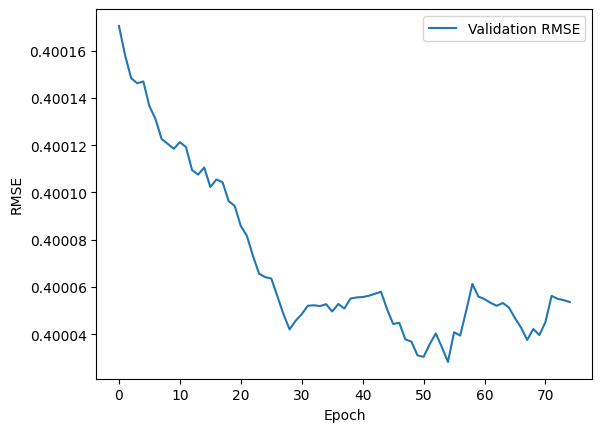

In [145]:
results = xgb_model.evals_result()
plt.plot(results['validation_0']['rmse'], label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

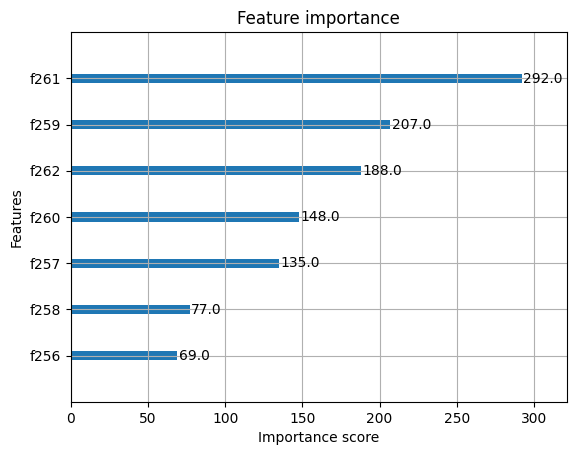

In [148]:

# 可视化特征重要性
xgb.plot_importance(xgb_model, max_num_features=20)
plt.show()

# 1. 增强特征工程
目标：引入更多时序相关特征，提升信息量

In [149]:
# 添加滞后特征（过去N分钟的涨跌幅）
merged_df["lag_1"] = merged_df.groupby("symbol")["涨跌幅"].shift(1)
merged_df["lag_5"] = merged_df.groupby("symbol")["涨跌幅"].shift(5)

# 添加滚动统计量
merged_df["rolling_mean_10"] = merged_df.groupby("symbol")["close"].transform(lambda x: x.rolling(10).mean())
merged_df["rolling_std_10"] = merged_df.groupby("symbol")["close"].transform(lambda x: x.rolling(10).std())

# 更新特征列
feature_cols += ["lag_1", "lag_5", "rolling_mean_10", "rolling_std_10"]

In [150]:
xgb_model = xgb.XGBRegressor(
    max_depth=5,           # 增加树深度
    n_estimators=2000,     # 更多树数量
    learning_rate=0.005,   # 更小学习率
    subsample=0.7,         # 增强随机性
    colsample_bytree=0.7,
    gamma=0.1,             # 引入正则化项
    reg_alpha=0.1,         # L1正则化
    reg_lambda=0.1,        # L2正则化
    early_stopping_rounds=50,  # 延长早停观察窗口
    eval_metric="rmse"
)

# 3. 多目标优化
目标：联合优化RMSE和方向准确性。

In [157]:
def custom_eval_metric(preds, dtrain):
    """
    preds: 模型预测值（浮点数组）
    dtrain: DMatrix对象，包含真实标签
    返回: (评估指标名称, 指标值)
    """
    labels = dtrain.get_label()  # 获取真实标签
    # 计算指标（例如方向准确性）
    correct = np.sum(np.sign(preds) == np.sign(labels))
    acc = correct / len(labels)
    return "direction_acc", acc  # 返回元组（指标名称, 值）

In [162]:
import xgboost as xgb
import numpy as np

# 转换数据为DMatrix格式
dtrain = xgb.DMatrix(X_train_boost_scaled, label=y_train)
dval = xgb.DMatrix(X_val_boost_scaled, label=y_val)

# 定义参数（必须包含目标函数）
params = {
    "objective": "reg:squarederror",  # 回归任务目标函数
    "max_depth": 4,
    "learning_rate": 0.01,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "eval_metric": "rmse"  # 内置评估指标
}

# 训练模型并添加自定义评估函数
evals_result = {}
# model = xgb.train(
#     params,
#     dtrain,
#     num_boost_round=1000,
#     evals=[(dtrain, "train"), (dval, "val")],
#     feval=custom_eval_metric,  # 关键：通过feval添加自定义函数
#     early_stopping_rounds=20,
#     evals_result=evals_result,
#     verbose_eval=10  # 每10轮打印一次评估结果
# )

In [161]:
print("XGBoost版本:", xgb.__version__)

XGBoost版本: 3.0.0


In [163]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, "train"), (dval, "val")],
    custom_metric=direction_accuracy,  # 使用正确参数名
    early_stopping_rounds=20,
    evals_result=evals_result,
    verbose_eval=10
)

[0]	train-rmse:0.56615	train-direction_acc:0.48862	val-rmse:0.40017	val-direction_acc:0.50880
[10]	train-rmse:0.56538	train-direction_acc:0.51118	val-rmse:0.40012	val-direction_acc:0.50880
[19]	train-rmse:0.56479	train-direction_acc:0.51158	val-rmse:0.40009	val-direction_acc:0.50880


In [172]:
# params = {
#     #"objective": "reg:squarederror",  # 回归任务目标函数
#     "max_depth": 4,
#     "learning_rate": 0.01,
#     "subsample": 0.8,
#     "colsample_bytree": 0.8,
#     "eval_metric": "rmse"  # 内置评估指标
# }

params = {
    "objective":        "reg:squarederror",  # 明确回归任务
    "eval_metric":      "rmse",              # 验证时用的指标
    "max_depth":        4,                   # 树深度：越小越不易过拟合
    "learning_rate":    0.01,                # 学习率：越小越稳定，但要更多轮数
    "subsample":        0.8,                 # 行采样：防止过拟合
    "colsample_bytree": 0.8,                 # 列采样：防止过拟合
    "gamma":            0.1,                 # 分裂最小损失减少量：越大剪的越厉害
    "min_child_weight": 1,                   # 叶子最小样本权重和：越大越保守
    "lambda":           1.0,                 # L2 正则化项
    "alpha":            0.0,                 # L1 正则化项
    "seed":             42,                  # 保证可复现
    # 如果你有 GPU，可以加上：
    # "tree_method": "gpu_hist", 
    # "predictor":   "gpu_predictor",
}

In [176]:
import shap

# 解释器初始化
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dval)

# 计算特征对方向预测的贡献
# 1. 获取预测方向
y_pred_val = model.predict(dval)
pred_direction = np.sign(y_pred_val)

# 2. 计算每个特征对方向预测的绝对SHAP值（均值）
direction_importance = np.mean(np.abs(shap_values), axis=0)

# 3. 筛选重要性高于阈值的特征
threshold = np.percentile(direction_importance, 75)  # 保留前25%重要特征
selected_features = np.where(direction_importance >= threshold)[0]

# 更新数据集
X_train_selected = X_train_boost_scaled[:, selected_features]
X_val_selected = X_val_boost_scaled[:, selected_features]

# 重新训练精简模型
dtrain_selected = xgb.DMatrix(X_train_selected, label=y_train)
dval_selected = xgb.DMatrix(X_val_selected, label=y_val)



In [177]:
model_selected = xgb.train(
    params,
    dtrain_selected,
    num_boost_round=2000,              # 轮数要跟 learning_rate 配合：lr 更小，轮数可适当加大
    evals=[(dtrain_selected, "train"), (dval_selected, "val")],
    early_stopping_rounds=50,          # 监控 50 轮内没提升就停
    evals_result=evals_result,
    verbose_eval=10
)

[0]	train-rmse:0.56615	val-rmse:0.40016
[10]	train-rmse:0.56537	val-rmse:0.40014
[20]	train-rmse:0.56470	val-rmse:0.40011
[30]	train-rmse:0.56413	val-rmse:0.40006
[40]	train-rmse:0.56364	val-rmse:0.40005
[50]	train-rmse:0.56321	val-rmse:0.40005
[60]	train-rmse:0.56283	val-rmse:0.40004
[70]	train-rmse:0.56247	val-rmse:0.40005
[80]	train-rmse:0.56211	val-rmse:0.40004
[90]	train-rmse:0.56169	val-rmse:0.40015
[100]	train-rmse:0.56134	val-rmse:0.40023
[110]	train-rmse:0.56100	val-rmse:0.40033
[120]	train-rmse:0.56070	val-rmse:0.40042
[127]	train-rmse:0.56042	val-rmse:0.40058


In [178]:
params = {
    "objective":        "reg:squarederror",
    "eval_metric":      "rmse",
    "max_depth":        4,
    "learning_rate":    0.005,       # 更小的 lr
    "subsample":        0.7,         # 更激进的行采样
    "colsample_bytree": 0.7,         # 更激进的列采样
    "gamma":            0.3,
    "min_child_weight": 3,
    "lambda":           1.5,
    "alpha":            0.5,
    "seed":             42,
}

cv_results = xgb.cv(
    params,
    dtrain_selected,
    num_boost_round=3000,
    nfold=5,
    early_stopping_rounds=30,
    metrics="rmse",
    seed=42,
    verbose_eval=50
)
print("Best CV RMSE:", cv_results["test-rmse-mean"].min())
print("Best rounds:", len(cv_results))


[0]	train-rmse:0.56619+0.00040	test-rmse:0.56622+0.00162
[50]	train-rmse:0.56446+0.00037	test-rmse:0.56469+0.00155
[100]	train-rmse:0.56322+0.00034	test-rmse:0.56365+0.00151
[150]	train-rmse:0.56225+0.00030	test-rmse:0.56284+0.00147
[200]	train-rmse:0.56136+0.00030	test-rmse:0.56212+0.00140
[250]	train-rmse:0.56052+0.00027	test-rmse:0.56144+0.00136
[300]	train-rmse:0.55977+0.00026	test-rmse:0.56085+0.00131
[350]	train-rmse:0.55910+0.00024	test-rmse:0.56034+0.00126
[400]	train-rmse:0.55847+0.00021	test-rmse:0.55986+0.00123
[450]	train-rmse:0.55792+0.00020	test-rmse:0.55946+0.00120
[500]	train-rmse:0.55741+0.00019	test-rmse:0.55911+0.00118
[550]	train-rmse:0.55689+0.00018	test-rmse:0.55873+0.00114
[600]	train-rmse:0.55643+0.00016	test-rmse:0.55843+0.00112
[650]	train-rmse:0.55597+0.00014	test-rmse:0.55812+0.00110
[700]	train-rmse:0.55552+0.00014	test-rmse:0.55781+0.00109
[750]	train-rmse:0.55509+0.00013	test-rmse:0.55751+0.00106
[800]	train-rmse:0.55468+0.00011	test-rmse:0.55724+0.00104


In [180]:
# from sklearn.model_selection import GridSearchCV
# import xgboost as xgb

# # 定义参数网格（精简版）
# param_grid = {
#     "max_depth": [3, 4],        # 控制树复杂度
#     "learning_rate": [0.01, 0.05],
#     "subsample": [0.7, 0.8],    # 随机采样样本
#     "gamma": [0, 0.1],          # 正则化项
#     "reg_alpha": [0, 0.1]       # L1正则化
# }

# # 初始化模型
# model = xgb.XGBRegressor(
#     n_estimators=300,
#     early_stopping_rounds=20,
#     eval_metric="rmse"
# )

# # 网格搜索（小规模快速搜索）
# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     cv=3,
#     scoring="neg_mean_squared_error",
#     verbose=2
# )

# # 执行搜索（在精选特征上运行，减少计算时间）
# grid_search.fit(X_train_selected, y_train)

# # 输出最优参数
# print("最优参数:", grid_search.best_params_)

In [181]:
final_model = xgb.train(
    params,
    xgb.DMatrix(np.vstack([X_train_selected, X_val_selected]), 
                label=np.hstack([y_train, y_val])),
    num_boost_round=3000
)


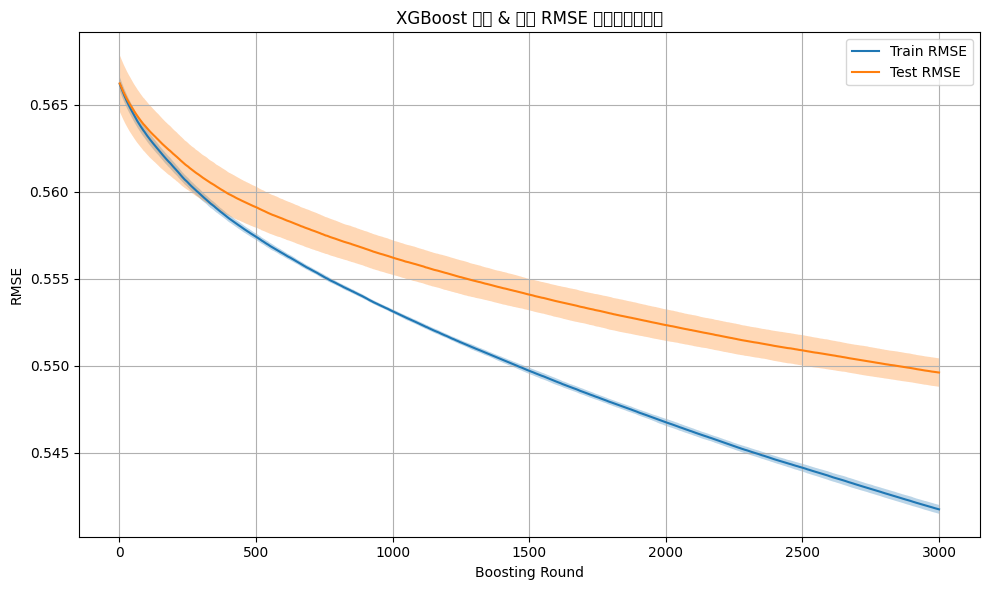

In [182]:
import matplotlib.pyplot as plt

# 假设 cv_results 已经存在，是 xgb.cv 的返回值 DataFrame
# 包含列: 'train-rmse-mean', 'train-rmse-std', 'test-rmse-mean', 'test-rmse-std'
iterations = range(1, len(cv_results) + 1)

plt.figure(figsize=(10, 6))

# 训练集 RMSE 平均值及标准差带
plt.plot(iterations, cv_results['train-rmse-mean'], label='Train RMSE')
plt.fill_between(
    iterations,
    cv_results['train-rmse-mean'] - cv_results['train-rmse-std'],
    cv_results['train-rmse-mean'] + cv_results['train-rmse-std'],
    alpha=0.3
)

# 验证集 RMSE 平均值及标准差带
plt.plot(iterations, cv_results['test-rmse-mean'], label='Test RMSE')
plt.fill_between(
    iterations,
    cv_results['test-rmse-mean'] - cv_results['test-rmse-std'],
    cv_results['test-rmse-mean'] + cv_results['test-rmse-std'],
    alpha=0.3
)

plt.title('XGBoost 训练 & 验证 RMSE 随迭代轮次变化')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [185]:
# 计算价格变化的自然波动（标准差）  
price_std = np.std(merged_df["close"].diff().dropna())  
print("价格变动标准差（市场噪声）:", price_std)  

价格变动标准差（市场噪声）: 9.180561827349623


In [186]:
params["max_depth"] = 5  
params["gamma"] = 0.1  

cv_results_v2 = xgb.cv(
    params,
    dtrain_selected,
    num_boost_round=5000,
    nfold=5,
    early_stopping_rounds=50,
    metrics="rmse",
    seed=42,
    verbose_eval=100
)

[0]	train-rmse:0.56617+0.00040	test-rmse:0.56621+0.00162
[100]	train-rmse:0.56212+0.00030	test-rmse:0.56285+0.00149
[200]	train-rmse:0.55952+0.00027	test-rmse:0.56084+0.00136
[300]	train-rmse:0.55725+0.00025	test-rmse:0.55917+0.00126
[400]	train-rmse:0.55531+0.00022	test-rmse:0.55781+0.00116
[500]	train-rmse:0.55370+0.00021	test-rmse:0.55673+0.00108
[600]	train-rmse:0.55223+0.00016	test-rmse:0.55577+0.00106
[700]	train-rmse:0.55087+0.00016	test-rmse:0.55493+0.00102
[800]	train-rmse:0.54958+0.00015	test-rmse:0.55414+0.00096
[900]	train-rmse:0.54839+0.00015	test-rmse:0.55342+0.00096
[1000]	train-rmse:0.54722+0.00014	test-rmse:0.55273+0.00095
[1100]	train-rmse:0.54610+0.00016	test-rmse:0.55213+0.00093
[1200]	train-rmse:0.54500+0.00016	test-rmse:0.55150+0.00094
[1300]	train-rmse:0.54397+0.00019	test-rmse:0.55092+0.00091
[1400]	train-rmse:0.54298+0.00022	test-rmse:0.55037+0.00091
[1500]	train-rmse:0.54201+0.00024	test-rmse:0.54987+0.00088
[1600]	train-rmse:0.54106+0.00025	test-rmse:0.54939+

In [187]:
print("Best CV RMSE:", cv_results["test-rmse-mean"].min())
print("Best rounds:", len(cv_results))

Best CV RMSE: 0.5496161995412752
Best rounds: 3000


验证集方向准确性: 52.959999999999994


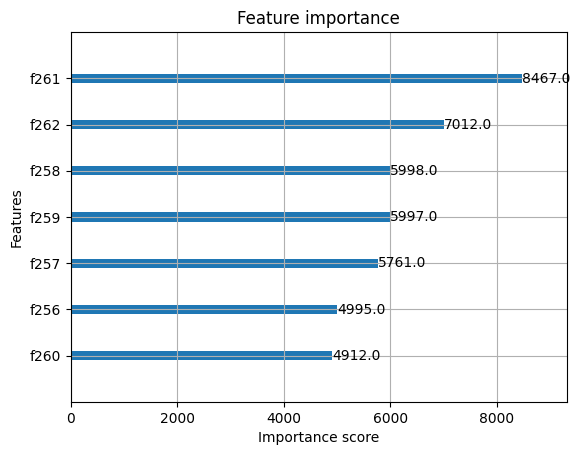

In [188]:
# 计算方向准确性  
y_pred = final_model.predict(xgb.DMatrix(X_val_selected))  
direction_acc = np.mean(np.sign(y_pred) == np.sign(y_val)) * 100  
print("验证集方向准确性:", direction_acc)  

# 可视化特征重要性  
xgb.plot_importance(final_model, max_num_features=20)  
plt.show()  

In [189]:
def directional_loss(y_pred, dtrain):
    y_true = dtrain.get_label()
    error = y_pred - y_true
    
    # 基础梯度（RMSE）
    grad = error
    hess = np.ones_like(error)
    
    # 方向惩罚项（超参数alpha控制强度）
    alpha = 5.0  # 大幅提升方向权重
    sign_mismatch = np.sign(y_pred) != np.sign(y_true)
    grad[sign_mismatch] += alpha * np.sign(y_pred[sign_mismatch])
    
    return grad, hess

# 更新模型参数
params["objective"] = directional_loss
params["eval_metric"] = "rmse"  # 同时监控RMSE

In [190]:
# 动量指标
merged_df["momentum_5"] = merged_df.groupby("symbol")["close"].pct_change(5)
merged_df["momentum_10"] = merged_df.groupby("symbol")["close"].pct_change(10)

# 波动率指标
merged_df["volatility_30"] = merged_df.groupby("symbol")["close"].transform(lambda x: x.rolling(30).std())

# 市场情绪指标（示例：价量背离）
merged_df["price_volume_divergence"] = (
    merged_df["close"].diff(5) / merged_df["volume"].rolling(5).mean()
)

# 更新特征列
feature_cols += ["momentum_5", "momentum_10", "volatility_30", "price_volume_divergence"]

In [193]:
# 计算价格变动绝对值
merged_df["price_change"] = merged_df.groupby("symbol")["close"].diff(30).abs()

# 保留前50%高波动样本
threshold = merged_df["price_change"].quantile(0.5)
filtered_df = merged_df[merged_df["price_change"] > threshold]

# 重新生成数据集
X_train_filtered, y_train_filtered = create_sequences(filtered_df,feature_cols)

In [197]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, LSTM, Attention,
    Lambda, Dense
)
from tensorflow.keras.models import Model


In [198]:

# 输入：过去60分钟特征（形状：(None, 60, num_features)）
# inputs = Input(shape=(60, len(feature_cols)))
# x = Conv1D(64, 3, activation="relu")(inputs)
# x = LSTM(128, return_sequences=True)(x)

inputs = Input(shape=(60, len(feature_cols)))


# #inputs = Input(shape=(60, len(feature_cols)))
# x = Conv1D(64, 3, activation="relu")(inputs)
# x = LSTM(128, return_sequences=True)(x)


x = Conv1D(64, 3, activation="relu")(inputs)
x = LSTM(128, return_sequences=True)(x)  # -> (batch, 60, 128)

# 注意力机制聚焦关键时间点
attention = Attention()([x, x])
#context = tf.reduce_sum(attention * x, axis=1)
context_seq = Attention()([x, x])

# context_seq, attn_weights = Attention(
#     return_attention_scores=True
# )([x, x])


#3context = Lambda(lambda t: tf.reduce_sum(t, axis=1))(context_seq)

context = Lambda(lambda t: tf.reduce_sum(t, axis=1))(context_seq)


#3outputs = Dense(1, activation="sigmoid")(context)
outputs = Dense(1, activation="sigmoid")(context)
# 输出：涨跌方向概率（二分类）
#outputs = Dense(1, activation="sigmoid")(context)  # 0=跌，1=涨


model = Model(inputs, outputs)
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

# model = Model(inputs, outputs)
# model.compile(
#     optimizer="adam",
#     loss="binary_crossentropy",
#     metrics=["accuracy"]
# )

# 编译模型（优化方向准确性）
# model = tf.keras.Model(inputs=inputs, outputs=outputs)
# model.compile(
#     optimizer="adam",
#     loss="binary_crossentropy",
#     metrics=["accuracy"]
# )

# 训练并验证方向准确性


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 60, 17)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 58, 64)    │      3,328 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ (None, 58, 128)   │     98,816 │ conv1d_18[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_19        │ (None, 58, 128)   │          0 │ lstm_17[0][0],    │
│ (Attention)         │                   │            │ lstm_17[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 128)       │          0 │ attention_19[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 1)         │        129 │ lambda_3[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 102,273 (399.50 KB)

 Trainable params: 102,273 (399.50 KB)

 Non-trainable params: 0 (0.00 B)

In [201]:
feature_cols

['open',
 'high',
 'low',
 'close',
 'volume',
 'openinterest',
 'MA5',
 'MA10',
 'RSI',
 'lag_1',
 'lag_5',
 'rolling_mean_10',
 'rolling_std_10',
 'momentum_5',
 'momentum_10',
 'volatility_30',
 'price_volume_divergence']

In [202]:
symbol_data

,Unnamed: 0,datetime,contract,symbol,exchange,open,high,low,close,openinterest,...,Volume_Change,Price_Volume_Corr,future_close,涨跌幅,hour,minute,session,涨跌幅_scaled,arima_residual,MA10
0,13,2017-01-03 09:13:00,HC1705,HC,SHFE,3372.0,3372.0,3362.0,3363.0,172022.0,...,-0.013410,0.196844,3356.0,-0.208147,9,13,Morning,-0.408166,3363.000000,3363.000000
1,14,2017-01-03 09:14:00,HC1705,HC,SHFE,3363.0,3366.0,3358.0,3365.0,172009.0,...,-0.051661,0.207903,3351.0,-0.416048,9,14,Morning,-0.807961,2.002386,3364.000000
2,15,2017-01-03 09:15:00,HC1705,HC,SHFE,3367.0,3372.0,3365.0,3366.0,171768.0,...,-0.128878,0.216773,3353.0,-0.386215,9,15,Morning,-0.750593,1.086440,3364.666667
3,16,2017-01-03 09:16:00,HC1705,HC,SHFE,3366.0,3371.0,3365.0,3366.0,171779.0,...,-0.236832,0.226767,3359.0,-0.207962,9,16,Morning,-0.407809,0.060852,3365.000000
4,17,2017-01-03 09:17:00,HC1705,HC,SHFE,3368.0,3370.0,3364.0,3367.0,171901.0,...,-0.033672,0.232937,3359.0,-0.237600,9,17,Morning,-0.464804,1.014362,3365.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505522,1093042,2025-04-18 13:55:00,HC2510,HC,SHFE,3187.0,3187.0,3184.0,3186.0,1386731.0,...,0.003212,-0.225452,3188.0,0.062775,13,55,Afternoon,0.112821,-0.038014,3180.700000
505523,1093043,2025-04-18 13:56:00,HC2510,HC,SHFE,3186.0,3187.0,3183.0,3184.0,1386638.0,...,-0.297878,-0.237943,3190.0,0.188442,13,56,Afternoon,0.354482,-2.001019,3181.500000
505524,1093044,2025-04-18 13:57:00,HC2510,HC,SHFE,3183.0,3185.0,3183.0,3183.0,1386938.0,...,0.011758,-0.240678,3192.0,0.282752,13,57,Afternoon,0.535842,-1.089495,3182.100000
505525,1093045,2025-04-18 13:58:00,HC2510,HC,SHFE,3183.0,3184.0,3181.0,3182.0,1387347.0,...,-0.122511,-0.236779,3194.0,0.377121,13,58,Afternoon,0.717315,-1.060930,3182.800000


In [ ]:
# 假设 merged_df 是包含特征的DataFrame
feature_cols = ["open", "high", "low", "close", "volume", "RSI"]
target_col = "涨跌幅"

def create_sequences(symbol_data, feature_cols, window=60):
    X, y = [], []
    data = symbol_data[feature_cols].values  # DataFrame列名索引
    labels = symbol_data[target_col].values
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(labels[i+window])
    return np.array(X), np.array(y)

# 生成序列
X_seq, y_seq = create_sequences(merged_df, feature_cols, window=60)

# 检查输出形状
print("X_seq 形状:", X_seq.shape)  # (样本数, 60, 特征数)
print("y_seq 形状:", y_seq.shape)  # (样本数,)

In [200]:
target_col = "涨跌幅"

# 提取特征和标签
X_data = merged_df[feature_cols].values
y_labels = merged_df[target_col].values

# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)

# 生成序列
window_size = 60
X_seq, y_seq = create_sequences(X_scaled, y_labels, window_size)

# 划分训练集和验证集
split = int(0.8 * len(X_seq))
X_train_seq, X_val_seq = X_seq[:split], X_seq[split:]
y_train_seq, y_val_seq = y_seq[:split], y_seq[split:]

# 转换为二分类标签
y_train_cls = (y_train_seq > 0).astype(float)
y_val_cls = (y_val_seq > 0).astype(float)

IndexError: arrays used as indices must be of integer (or boolean) type

In [199]:
model.fit(
    X_train_seq, (y_train > 0).astype(float),  # 标签转换为0/1
    validation_data=(X_val_seq, (y_val > 0).astype(float)),
    epochs=50,
    batch_size=64
)

NameError: name 'X_train_seq' is not defined